In [1]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

import tensorflow as tf
import pandas as pd

## Train/Load the model

In [2]:
## Train the model
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

## Load the saved model
#model = tf.keras.models.load_model('./model/')

model.summary()
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Metal device set to: Apple M2 Pro


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


## Skip to Inference if load the saved model

In [3]:
!pwd

/Users/tony/Project/Testing Bert


In [54]:
csv_file_path_1 = "./datasets/data_1.csv" #dataset source:https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis?resource=download
dataset_1 = pd.read_csv(csv_file_path_1)
#dataset_1 = dataset_1[dataset_1['Sentiment'] != 'neutral']
dataset_1 = dataset_1.dropna()
dataset_1 = dataset_1.reset_index()
dataset_1 = dataset_1.drop('index', axis=1)

# csv_file_path_2 = "./datasets/data_2.csv" #dataset source:https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news
# dataset_2 = pd.read_csv(csv_file_path_2, header=None, encoding="ISO-8859-1") 
# #print(dataset_2.columns)

# csv_file_path_3 = "./datasets/data_3.csv" #dataset source:https://www.kaggle.com/datasets/avisheksood/stock-news-sentiment-analysismassive-dataset/code?resource=download
# dataset_3 = pd.read_csv(csv_file_path_3, header=None) 
# dataset_3.drop(dataset_3.columns[0], axis=1, inplace=True)
# dataset_3.drop(dataset_3.index[0], inplace=True)
# dataset_3.rename(columns={1: 'Sentiment', 2:'Sentence'}, inplace=True)
# #dataset_3['Sentiment'] = [dataset_3['Sentiment'].astype(int)

# #clean data
# dataset_3 = dataset_3.dropna()
# dataset_3 = dataset_3.reset_index()
# dataset_3.drop(columns='index', inplace=True)

lengths = [len(dataset_1['Sentence'][x].split(' ')) for x in range(len(dataset_1))]
max_len = max(lengths)
min_len = min(lengths)
print('max length sentence in dataset:', max_len)
print('min length sentence in dataset:', min_len)  #max length of sentences
print([dataset_1['Sentence'][x] for x in range(len(dataset_1)) if len(dataset_1['Sentence'][x].split(' ')) < 3])

# print()
# for i in range(20):
#     print(dataset_1['Sentiment'][i])
#     print(dataset_1['Sentence'][i])

#Check data types
#print(type(dataset_1['Sentence'][0]), type(dataset_1['Sentiment'][0]),type(dataset_3['Sentence'][0]),  type(dataset_3['Sentiment'][0]))

max length sentence in dataset: 81
min length sentence in dataset: 2
['$TSLA recall', 'long $AAPL', 'Welcome !', 'Long $PCLN', '$amzn breaking', '$NEON oversold', '$NVDA sideways']


In [57]:
pd.set_option('display.max_colwidth', 100)  # Set the maximum column width
pd.set_option('display.max_rows', 10)  # Set the maximum column width

dataset_1 = dataset_1[dataset_1['Sentiment']=='neutral']
dataset_1

,Sentence,Sentiment
3,"According to the Finnish-Russian Chamber of Commerce , all the major construction companies of F...",neutral
4,"The Swedish buyout firm has sold its remaining 22.4 percent stake , almost eighteen months after...",neutral
9,"The Stockmann department store will have a total floor space of over 8,000 square metres and Sto...",neutral
13,Viking Line has canceled some services .,neutral
14,"Ahlstrom Corporation STOCK EXCHANGE ANNOUNCEMENT 7.2.2007 at 10.30 A total of 56,955 new shares ...",neutral
...,...,...
5833,"In 2008 , Kemira recorded revenue of approximately EUR 2.8 billion and had a staff of 9,400 .",neutral
5834,Investments in product development stood at 6.0 mln euro ( $ 8.8 mln ) .,neutral
5838,Nordic Walking was first used as a summer training method by cross-country skiers .,neutral
5839,"According shipping company Viking Line , the EU decision will have a significant financial impact .",neutral


,Sentence,Sentiment


In [5]:
def encode_dataset(data, tokenizer, max_length=128):
    input_ids, attention_masks, labels = [], [], []

    sentiment_map = {"positive": 1, "negative": 0, "neutral":0, "1": 1, "0": 0, 1:1, 0:0}

    for index, row in data.iterrows():
        inputs = tokenizer.encode_plus(
            row["Sentence"],
            add_special_tokens=True,
            max_length=max_length,
            padding="max_length",
            truncation=True,
        )

        input_ids.append(inputs["input_ids"])
        attention_masks.append(inputs["attention_mask"])
        labels.append(sentiment_map[row["Sentiment"]])

    return (
        tf.data.Dataset.from_tensor_slices(
            ({"input_ids": input_ids, "attention_mask": attention_masks}, labels)
        ),
        max_length,
    )

In [6]:
dataset = dataset_1
tf_data, max_length = encode_dataset(dataset, tokenizer)

# number of individual samples in the dataset
num_samples = tf.data.experimental.cardinality(tf_data).numpy()
print("Number of samples:", num_samples)

# Train-test-validation split sizes
train_size = int(num_samples * 0.7)
test_size = int(num_samples * 0.15)
val_size = num_samples - train_size - test_size

BATCH_SIZE = 8

# Shuffle
tf_data = tf_data.shuffle(num_samples)

# Split
train_data = tf_data.take(train_size)
remaining_data = tf_data.skip(train_size)
test_data = remaining_data.take(test_size)
val_data = remaining_data.skip(test_size)

# Apply batching and prefetching to each split
train_data = train_data.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_data = test_data.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
val_data = val_data.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

print("Number of samples in each split:", tf.data.experimental.cardinality(train_data), tf.data.experimental.cardinality(test_data), 
tf.data.experimental.cardinality(val_data))

Number of samples: 2712
Number of samples in each split: tf.Tensor(238, shape=(), dtype=int64) tf.Tensor(51, shape=(), dtype=int64) tf.Tensor(51, shape=(), dtype=int64)


In [7]:
print(tf_data)
print(train_data)
tf.config.list_physical_devices(
    device_type=None
)

<_ShuffleDataset element_spec=({'input_ids': TensorSpec(shape=(128,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(128,), dtype=tf.int32, name=None)}, TensorSpec(shape=(), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
#Training
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)  #use tf.keras.optimizers.legacy.Adam for m1
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, min_lr=1e-10)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

EPOCHS = 3

device = "/GPU:0" if tf.config.list_physical_devices("GPU") else "/CPU:0"
with tf.device(device):
    print(device)
    history = model.fit(train_data, epochs=EPOCHS, validation_data=val_data, callbacks=[reduce_lr])
    
# model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
#               metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

/GPU:0
Epoch 1/3


2023-06-01 17:53:23.867796: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


238/238 [==============================] - 126s 435ms/step - loss: 0.4397 - accuracy: 0.8019 - val_loss: 0.1701 - val_accuracy: 0.9485 - lr: 3.0000e-05
Epoch 2/3
238/238 [==============================] - 85s 357ms/step - loss: 0.2054 - accuracy: 0.9268 - val_loss: 0.1178 - val_accuracy: 0.9730 - lr: 3.0000e-05
Epoch 3/3
238/238 [==============================] - 86s 360ms/step - loss: 0.1365 - accuracy: 0.9505 - val_loss: 0.0446 - val_accuracy: 0.9853 - lr: 3.0000e-05


## Inference

In [9]:

def decode_dataset(encoded_dataset, tokenizer, max_length=128):
    decoded_texts = []
    labels = []

    reverse_sentiment_map = {1: "positive", 0: "negative"}

    # Unbatch the dataset
    unbatched_dataset = encoded_dataset.unbatch()

    for sample in unbatched_dataset.as_numpy_iterator():
        input_ids = sample[0]["input_ids"]
        attention_mask = sample[0]["attention_mask"]
        label = sample[1]

        # Decode the input_ids back to text
        decoded_text = tokenizer.decode(input_ids, skip_special_tokens=True)
        decoded_texts.append(decoded_text)

        # Convert the label back to sentiment text
        labels.append(reverse_sentiment_map[label])

    # Create a DataFrame with the decoded texts and labels
    decoded_data = pd.DataFrame({"Sentence": decoded_texts, "Sentiment": labels})

    return decoded_data

In [10]:
#pred_sentences = ['''German economy entered recession as inflation hurts consumers Reuters May 25, 20236:13 PM GMT+8Updated 6 min ago Outbreak of the coronavirus disease (COVID-19) pandemic in Berlin People pass by the Europa-Center shopping mall, amid the coronavirus disease (COVID-19) pandemic in Berlin, Germany, December 14, 2020. REUTERS/Michele Tantussi BERLIN, May 24 (Reuters) - The German economy was in recession in early 2023 after households spending in Europe's economic engine finally succumbed to the pressure of high inflation. Gross domestic product fell by 0.3% in the first quarter of the year when adjusted for price and calendar effects, a second estimate from the statistics office showed on Thursday. This follows a decline of 0.5% in the fourth quarter of 2022. A recession is commonly defined as two successive quarters of contraction. Advertisement · Scroll to continue German GDP data showed "surprisingly negative signals," Finance Minister Christian Lindner said on Thursday. He added that comparing Germany with other highly developed economies, the economy was losing potential for growth. "I don't want Germany to play in a league in which we have to relegate ourselves to the last positions," he said, referring to the forecasts of the International Monetary Fund, which forecast a recession in 2023 only in Germany and Britain among European countries. "Under the weight of immense inflation, the German consumer has fallen to his knees, dragging the entire economy down with him," Andreas Scheuerle, an analyst at DekaBank, said. Advertisement · Scroll to continue Household consumption was down 1.2% quarter-on-quarter after price, seasonal and calendar adjustments. Government spending also decreased significantly by 4.9% on the quarter. "The warm winter weather, a rebound in industrial activity, helped by the Chinese reopening, and an easing of supply chain frictions, were not enough to get the economy out of the recessionary danger zone," ING's global head of macro Carsten Brzeski said. By contrast, investment was up in the first three months of the year, following a weak second half of 2022. Investment in machinery and equipment increased by 3.2% compared with the previous quarter, while investment in construction went up 3.9% on quarter. There were also positive contributions from trade. Exports rose 0.4%, while imports fell 0.9%. "The massive rise in energy prices took its toll in the winter half-year," Commerzbank's chief economist Joerg Kraemer said. Advertisement · Scroll to continue A recession could not be avoided and now the question is whether there will be any recovery in the second half of the year. "Looking beyond the first quarter, the optimism at the start of the year seems to have given way to more of a sense of reality," ING's Brzeski said. A drop in purchasing power, thinned-out industrial order books, aggressive monetary policy tightening, and the expected slowdown of the U.S. economy, all argue in favour of weak economic activity. Following Wednesday's decline in the Ifo business climate, all key leading indicators in the manufacturing sector are now falling, Kraemer from Commerzbank said. The German Bundesbank, however, expects the economy to grow modestly in the second quarter as a rebound in industry more than offsets stagnating household consumption and a slump in construction, according to a monthly economy report published on Wednesday.''',
#                 '''Exclusive: Asia-focused HSBC puts 12 countries on exit watchlist By Lawrence White May 24, 20237:05 PM GMT+8Updated a day ago Georges Elhedery, HSBC's CFO, gestures during an interview with Reuters in Dubai Georges Elhedery, HSBC's CFO, gestures during an interview with Reuters in Dubai, United Arab Emirates August 7, 2017. REUTERS/Tom Arnold/ Summary Companies Reviews presence in smaller markets to chase bigger Asian growth Looking to add 2,000 Chinese wealth managers over next two years LONDON, May 24 (Reuters) - HSBC (HSBA.L) is reviewing a possible exit from as many as 1 in 5 of the countries the lender operates in to sharpen its focus on Asian expansion, Chief Financial Officer Georges Elhedery told Reuters in his first interview since taking the role. These reviews, which could see the British bank deciding to sell or streamline businesses in 12 countries, follow pressure from Chinese shareholder Ping An Insurance (601318.SS), which wants HSBC to prioritise growth in its money-spinning Asian business which generates 78% of group profit. Advertisement · Scroll to continue "Some of these will have slower progress than others, and none of them is material enough on its own to change the profile of the overall business, but as we progress through and execute on these assessments, we do expect them to contribute towards that shift to Asia," Elhedery said, declining to disclose which markets were under review or the time frame for the processes. HSBC's ongoing pivot to Asia has already triggered planned sales of all or parts of its businesses in France, Greece, Russia and Canada, announced in the last two years. While the markets under review may be relatively small, the move is significant in showing the pressure HSBC faces to shrink its once globe-spanning local banking businesses in order to lift returns and appease its investors. Advertisement · Scroll to continue HSBC does not break out the results of every individual country in which it operates in its overall results, making identifying underperforming markets challenging. But its businesses in Europe and Latin America may be particularly under the microscope, with the former region making a net loss in 2022 thanks to restructuring and the costs booked to its headquarters in the region. Latin America contributed just under 5% of group profit. One country not currently under review is Mexico, Elhedery said, despite debate among analysts and investors on the bank's future presence in the country. "Mexico is performing very well for us," the veteran banker said, pointing to the U.S.-Mexico-Canada trade agreement and to the China Plus One strategy, which have supported economic growth in Mexico. "Some 70% of client acquisition in the retail business is through employees of the multinational companies that HSBC banks in Mexico, so there are strong synergies with the wholesale business and the package as a whole makes sense for us," he added. Advertisement · Scroll to continue BIGGER DEALS PRESENT WIDER CHALLENGES Ping An was the only major HSBC investor backing proposals to force the bank to publish regular assessments on the merits of dividing its franchise along Asian and Western lines at HSBC's annual shareholder meeting on May 5. A spokesperson for Ping An said the company had no further comment. The failure of Ping An to secure further backing for a split has afforded HSBC Chairman Mark Tucker, Chief Executive Noel Quinn and newly-promoted Elhedery some breathing space to pursue greater profit growth on their terms. "It's overwhelmingly clear what the majority of our shareholders bar one expect from us, and therefore all our focus now is on delivering for the business and for our customers," Elhedery said. Wider challenges include executing critical asset sales, managing a price war with rivals as interest rate hikes peak, and dealing with rising political tensions between East and West, analysts and investors said. The bank on April 14 said a nominal 1 euro ($1.10) deal to offload its French retail business could falter after interest rate hikes upped the amount of capital Cerberus-backed buyer, My Money, will need to secure regulatory approval. HSBC had said it expected to incur a loss of around $2.3 billion on the disposal should it go ahead. Elhedery said negotiations are ongoing but HSBC would walk away from the deal to protect shareholder value if necessary. HSBC's larger $10 billion sale of its Canada unit has also been delayed until next year, as it battles to ensure a smooth transition of systems to the buyer, Royal Bank of Canada. Failure to complete either of those deals could have wider consequences for HSBC. "In the short term, the risk that the French and Canadian disposals don't complete ... could put a spanner in the works of its Asia pivot and spark a fresh wave of activism," said Susannah Streeter, head of money and markets at Hargreaves Lansdown. Beyond dealmaking, Elhedery said the medium-term challenge is sustaining momentum in revenue growth, with the fillip from rising central bank interest rates worldwide already tapering off. The bank is trying to increase income through fee-based products and services, especially in China and Hong Kong where economies are beginning to normalise following the lifting of COVID-19 related restrictions. HSBC is on track to hire around 2,000 private wealth managers in China's insurance sector over the next two years, adding to the 1,000 hired last year, Elhedery said.''']

decode_test = decode_dataset(val_data, tokenizer=tokenizer)
pred_sentences = decode_test
print(pred_sentences)

print(len(val_data), train_data, test_data)


                                              Sentence Sentiment
0    a helsinki : eliiv today reported eps of eur1....  positive
1    eps from continuing operations came in at 0. 3...  positive
2    qualcomm : 10 % dividend increase rewards pati...  positive
3    efficiency programs totalling 100 million euro...  positive
4    ` ` we're delighted with the move'' says morna...  positive
..                                                 ...       ...
403  @ renatta @ fr0van @ kjepeneter @ rptl strong ...  positive
404  cash flow after investments amounted to eur45m...  negative
405  thank you $ goog ( google alphabet ) and $ fb ...  positive
406  should you buy jumbo yielders british american...  positive
407  finnish office supplies and computer accessori...  positive

[408 rows x 2 columns]
51 <_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None)}, TensorSpec(s

references:
https://www.reuters.com/business/finance/asia-focused-hsbc-puts-12-countries-exit-watchlist-2023-05-24/
https://www.reuters.com/markets/europe/germany-enters-recession-2023-05-25/

In [11]:
# pred_sentences = dataset_3['Sentence'].tolist()[0:20]
# print(pred_sentences)

# #Predictons
# tf_batch = tokenizer(pred_sentences, max_length=512, padding=True, truncation=True, return_tensors='tf')
# tf_outputs = model(tf_batch)
# #tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
# tf_predictions = tf.nn.softmax(tf_outputs['logits'], axis=-1)
# labels = ['Negative','Positive']
# label = tf.argmax(tf_predictions, axis=1)
# label = label.numpy()
# for i in range(len(pred_sentences)):
#   print(pred_sentences[i], ": \n\n", labels[label[i]], "\n\n")


In [12]:
# Save model
model.save('./model/')

INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


## Model performance on the larger dataset

['a helsinki : eliiv today reported eps of eur1. 13 for 2009, an increase over eps of eur1. 12 in 2008.', 'eps from continuing operations came in at 0. 30 eur, up from 0. 17.', 'qualcomm : 10 % dividend increase rewards patient investors, the future looks bright https : / / t. co / tjjvpqhhqd $ qcom', 'efficiency programs totalling 100 million euros are under way in finnair.', "` ` we're delighted with the move'' says morna cowie, co - owner, above, ` ` it's double the size of our current shop and has a lovely feel to it.''", 'alma media expects its net sales to increase as forecast previously.', '$ hitk resuming advance into new historical highs.', 'press : serco set to appoint roy gardner, ex - centrica, as chairman - ft', 'astrazeneca wins fda approval for key new lung cancer pill', '$ ko had missed earnings expectations for the last two quarters, so today ’ s strong results came as a major surprise http : / / stks. co / d0rhf', 'slowly adding some $ fio here but gotta be careful. t

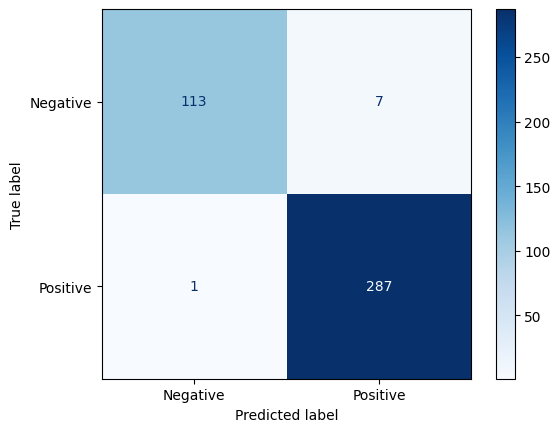

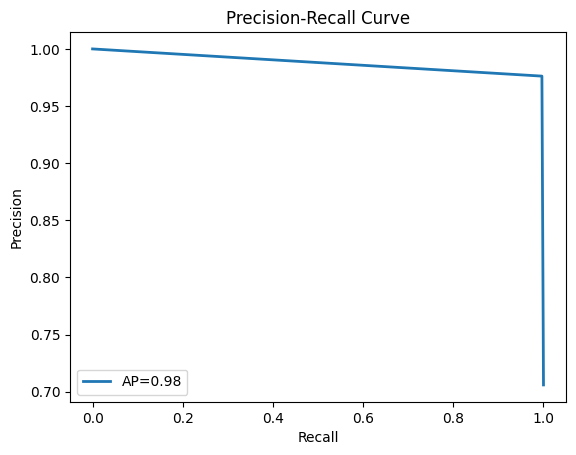

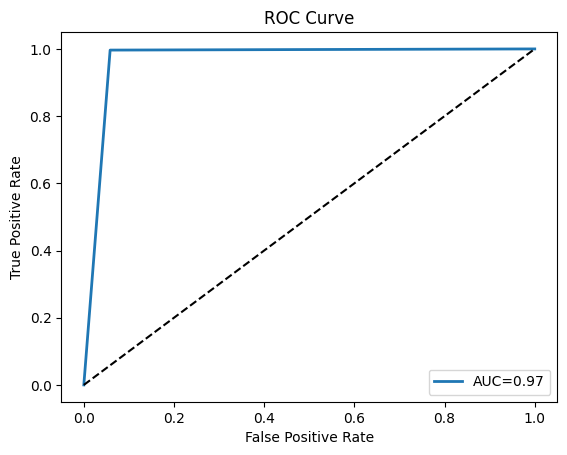

╒═══════════╤══════════╕
│ Metric    │    Value │
╞═══════════╪══════════╡
│ Accuracy  │ 0.980392 │
├───────────┼──────────┤
│ Precision │ 0.97619  │
├───────────┼──────────┤
│ Recall    │ 0.996528 │
├───────────┼──────────┤
│ F1 Score  │ 0.986254 │
╘═══════════╧══════════╛


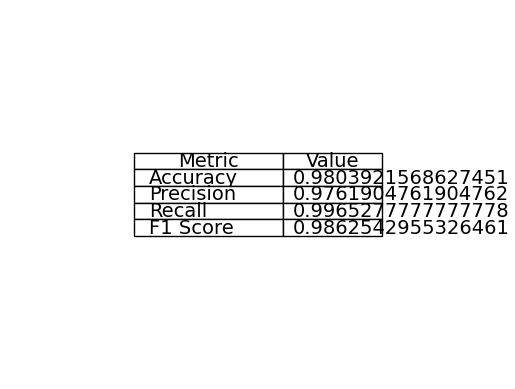

In [22]:
pd.options.display.max_colwidth = 100

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Preprocess data
pred_sentences = decode_test['Sentence'].tolist()
print(pred_sentences)

#Predictons
tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
#load model
#model = tf.keras.models.load_model('./')

tf_outputs = model(tf_batch)
#tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
tf_predictions = tf.nn.softmax(tf_outputs['logits'], axis=-1)
labels = ['Negative','Positive']
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
# for i in range(len(pred_sentences)):
#   print(pred_sentences[i], ": \n\n", labels[label[i]], "\n\n")

# Convert the predicted probabilities to binary values (0 or 1)
predicted_sentiments = label.tolist()
map = {"positive": 1, "negative": 0}
actual_sentiments = [map[x] for x in decode_test['Sentiment'].tolist()]

print(predicted_sentiments)
print(type(predicted_sentiments))
print(actual_sentiments)
print(type(actual_sentiments))

# Calculate the accuracy of your model's predictions
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
precision_recall_curve, average_precision_score, auc, roc_curve, roc_auc_score
from tabulate import tabulate

# Confusion Matrix
cm = confusion_matrix(actual_sentiments, predicted_sentiments)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')
plt.show()


# 2. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(actual_sentiments, predicted_sentiments)
average_precision = average_precision_score(actual_sentiments, predicted_sentiments)
plt.plot(recall, precision, label='AP={0:0.2f}'.format(average_precision), lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


# 3. ROC Curve
fpr, tpr, _ = roc_curve(actual_sentiments, predicted_sentiments)
roc_auc = roc_auc_score(actual_sentiments, predicted_sentiments)
plt.plot(fpr, tpr, label='AUC={0:0.2f}'.format(roc_auc), lw=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


# Calculate the metrics
accuracy = accuracy_score(actual_sentiments, predicted_sentiments)
precision = precision_score(actual_sentiments, predicted_sentiments)
recall = recall_score(actual_sentiments, predicted_sentiments)
f1 = f1_score(actual_sentiments, predicted_sentiments)

# Print the table
metrics_table = [['Accuracy', accuracy],
                 ['Precision', precision],
                 ['Recall', recall],
                 ['F1 Score', f1]]

print(tabulate(metrics_table, headers=['Metric', 'Value'], tablefmt='fancy_grid'))





In [14]:
!pip list | grep learn

scikit-learn             1.2.2
